# Bayes Opt with GRF

## Objectives

### Here is what we want to show:


**The Killer Results** (Compared to Exact Diffusion):
   1. Bayes Opt is better than random search
   2. GRF is faster
   3. GRF with arbitrary parameterization is getting better result on average
   4. GRF has sparse kernel covariance matrix (the two axis curve with sparsity / regret)

### The Experiment Setup

**Algorithms to use**
1. Random Search
2. Exact Diffusion
3. PoFM with arbitrary parameterization
4. GRF with arbitrary parameterization

**Metrics to use**
1. Normalized Regret after a fixed number of iterations
2. (Make it eazy for the code to store the evolution of the regret)


**Visualizations to show**
1. Convergence of the Best Value found against Bayes Opt Iteration (with the four models)
2. Evolution of normalized regret after 20 steps, against the number of random walker (with the sparsity plot)

## Setup the Graph and Synthesize Data

In [1]:
import tensorflow as tf
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
import networkx as nx
from gpflow.utilities import print_summary
import tensorflow_probability as tfp
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [2]:
import sys
import os
project_root = os.path.abspath("../..")
sys.path.append(project_root)

In [3]:
from efficient_graph_gp.graph_kernels import diffusion_kernel, get_normalized_laplacian, generate_noisy_samples
from efficient_graph_gp.gpflow_kernels import GraphDiffusionKernel, GraphGeneralPoFMKernel, GraphGeneralFastGRFKernel
from utils import plot_network_graph, plot_gp_fit, compute_fro

In [4]:
# def gp_training(X,Y,X_new, graph_kernel):
#     model = gpflow.models.GPR(data=(X, Y), kernel=graph_kernel, mean_function=None)
#     # model.likelihood.variance.prior = tfp.distributions.LogNormal(
#     # loc=tf.cast(np.log(0.07), tf.float64),
#     # scale=tf.cast(0.5, tf.float64))
#     gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables)
#     mean, variance = model.predict_f(X_new)
#     stddev = tf.sqrt(variance)
#     return model, mean, stddev

def gp_training(model, X_new):
    gpflow.optimizers.Scipy().minimize(model.training_loss, model.trainable_variables)
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return model, mean, stddev

def gp_inference(model, X_new):
    mean, variance = model.predict_f(X_new)
    stddev = tf.sqrt(variance)
    return model, mean, stddev

In [5]:
def plot_2d(Z, mesh_size, ax, points=None, highlight=None, title='', cmap='viridis'):
    Z2D = Z.reshape(mesh_size, mesh_size)
    x = np.arange(mesh_size)
    y = np.arange(mesh_size)
    Xg, Yg = np.meshgrid(x, y)
    cs = ax.contourf(Xg, Yg, Z2D, levels=25, cmap=cmap)
    if points is not None:
        px, py = points % mesh_size, points // mesh_size
        ax.scatter(px, py, marker='x', c='white', s=50)
    if highlight is not None:
        hx, hy = highlight % mesh_size, highlight // mesh_size
        ax.scatter(hx, hy, marker='*', c='red', s=80)
    ax.set_title(title)
    return cs

In [6]:
# Grid Setups
mesh_size = 15
num_nodes = mesh_size**2
graph_type = '2D_mesh' # 'line', 'random', '2D_mesh'

In [7]:
if graph_type == 'line':
    adjacency_matrix = np.eye(num_nodes, k=1) + np.eye(num_nodes, k=-1)  # Circular adjacency matrix
elif graph_type == 'random':
    probability = 0.1  # Probability of edge creation
    G = nx.erdos_renyi_graph(num_nodes, probability, directed=False)  # Ensure the graph is undirected
    adjacency_matrix = nx.to_numpy_array(G)  # Convert to adjacency matrix
elif graph_type == '2D_mesh':
    adjacency_matrix = nx.adjacency_matrix(nx.grid_2d_graph(mesh_size, mesh_size)).todense()

In [8]:
# Data Synthesis Setup
beta_sample = 10
kernel_std = 100

In [9]:
K_true = kernel_std * diffusion_kernel(adjacency_matrix, beta_sample)
Y = generate_noisy_samples(K_true, noise_std=1, seed=10)
X = tf.convert_to_tensor(np.arange(num_nodes, dtype=np.float64).reshape(-1, 1))  # Input features (nodes)

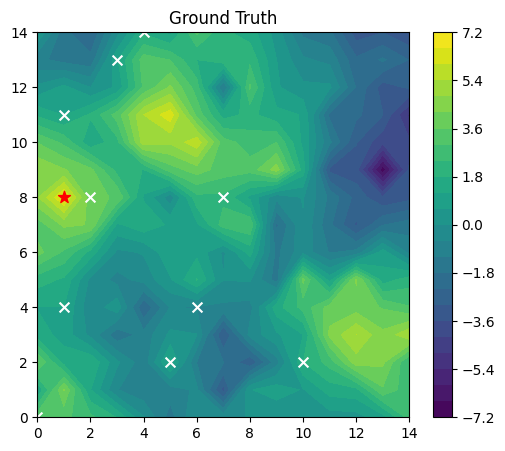

In [10]:
# Ground truth best
gt_best_point = np.argmax(Y)
gt_best_value = Y[gt_best_point]

# Initial subsampling
subsample_factor = 20
sub_idx = np.random.choice(num_nodes, min(num_nodes // subsample_factor, 10), replace=False)
X_sub = X.numpy()[sub_idx]
Y_sub = Y[sub_idx]

# Visualization the Ground Truth surface, overlayed with the initial subsampling, with colour bar
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_2d(Y, mesh_size, ax, points=sub_idx, highlight=gt_best_point, title='Ground Truth')
plt.colorbar(plot_2d(Y, mesh_size, ax, points=sub_idx, highlight=gt_best_point, title='Ground Truth'))
plt.show()

## Learn the Hyperparameters

### Learn the Hyperparameters for the GRF Kernels

In [11]:
MAX_WALK_LENGTH = 3

In [12]:
ground_truth_pofm_kernel = GraphGeneralPoFMKernel(adjacency_matrix=adjacency_matrix,
                                                  max_walk_length=MAX_WALK_LENGTH)         

In [13]:
model = gpflow.models.GPR(data=(X, Y), kernel=ground_truth_pofm_kernel, mean_function=None)
model, _ , _ = gp_training(model, X)
print_summary(model) 

╒═════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════════════════╕
│ name                        │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                           │
╞═════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════════════════╡
│ GPR.kernel.modulator_vector │ Parameter │ Identity         │         │ True        │ (3,)    │ float64 │ [  6.09937 -11.32072   4.53659] │
├─────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────────────────┤
│ GPR.likelihood.variance     │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.496510223938133               │
╘═════════════════════════════╧═══════════╧══════════════════╧═════════╧═════════════╧═════════╧═════════╧═════════════════════════════════╛


In [14]:
ground_truth_hyperparameters = {
    'modulator_vector': model.kernel.modulator_vector.numpy(),
    'variance': model.likelihood.variance.numpy()
}

## Experiment 2: Bayes Opt Performance of the GRF Kernel v.s. # Random Walkers

In [15]:
NUM_REPEATS = 500
SEEDS = np.arange(NUM_REPEATS)
NUM_ITER = 30
MAX_WALK_LENGTH = 3
P_HALT = 0.1

In [16]:
def kernel_sparsity(kernel_matrix):
    return np.count_nonzero(kernel_matrix) / kernel_matrix.size


walk_per_node_list = [16, 64, 256, 1024, 4096, 16384, 65536]
GRF_kernels = []
print("Precomputing GRF kernels...")
modulator_vector = ground_truth_hyperparameters['modulator_vector']


for walks_per_node in walk_per_node_list:
    kernel = GraphGeneralFastGRFKernel(
        adjacency_matrix=adjacency_matrix,
        walks_per_node=walks_per_node,
        p_halt=P_HALT,
        max_walk_length=MAX_WALK_LENGTH,
        modulator_vector=modulator_vector
    )
    pseudo_modulation_tensor = tf.convert_to_tensor(modulator_vector, dtype=tf.float64)
    pseudo_kernel = kernel.grf_kernel(pseudo_modulation_tensor).numpy()
    sparsity = kernel_sparsity(pseudo_kernel)
    GRF_kernels.append({
        'walks_per_node': walks_per_node,
        'kernel': kernel,
        'sparsity': sparsity
    })

Precomputing GRF kernels...


Random walks: 100%|██████████| 225/225 [03:24<00:00,  1.10it/s]


In [17]:
GRF_results = []
    
# Add random search baseline
print("Running Random Search baseline...")
for seed in tqdm(SEEDS, desc="Random Search"):
    np.random.seed(seed)
    tf.random.set_seed(seed)

    sub_idx = np.random.choice(num_nodes, min(num_nodes // subsample_factor, 5), replace=False)
    X_sub = X.numpy()[sub_idx]
    Y_sub = Y[sub_idx]

    best_val = -np.inf

    for i in range(NUM_ITER):
        next_idx = np.random.choice(num_nodes, 1)[0]
        next_val = Y[next_idx]

        if next_val > best_val:
            best_val = next_val

        sub_idx = np.append(sub_idx, next_idx)
        X_sub = X.numpy()[sub_idx]
        Y_sub = Y[sub_idx]

        GRF_results.append({
            "walks_per_node": 0,  # Use -1 or 'random' to denote the baseline
            "sparsity": np.nan,
            "seed": seed,
            "iteration": i + 1,
            "best_value": best_val,
            "ground_truth_best": gt_best_value[0] if hasattr(gt_best_value, '__getitem__') else gt_best_value
        })
    
print(f"Running Bayes Opt with GRF kernels...")

for kernel_dict in GRF_kernels:
    wpn = kernel_dict['walks_per_node']
    kernel = kernel_dict['kernel']
    sparsity = kernel_dict['sparsity']
    
    for seed in tqdm(SEEDS, desc=f"walks_per_node: {wpn}"):
        np.random.seed(seed)
        tf.random.set_seed(seed)
        sub_idx = np.random.choice(num_nodes, min(num_nodes // subsample_factor, 5), replace=False)
        X_sub = X.numpy()[sub_idx]
        Y_sub = Y[sub_idx]
        best_val = -np.inf
        
        for i in range(NUM_ITER):
            try:
                model =  gpflow.models.GPR(data=(X_sub, Y_sub), kernel=kernel, mean_function=None)
                model, mean, stddev = gp_inference(model, X_sub)
                thompson = model.predict_f_samples(X, 1).numpy().ravel()
                next_idx = np.argmax(thompson)
            except Exception as e:
                print(f"[Warning] Iteration {i+1}, seed {seed}, walks_per_node {wpn}: gp_inference failed.")
                print("[Warning] Replacing with random search.")
                next_idx = np.random.choice(num_nodes, 1)[0]

            next_val = Y[next_idx]
            if next_val > best_val:
                best_val = next_val
            sub_idx = np.append(sub_idx, next_idx)
            X_sub = X.numpy()[sub_idx]
            Y_sub = Y[sub_idx]
           
            GRF_results.append({
                "walks_per_node": wpn,
                "sparsity": sparsity,
                "seed": seed,
                "iteration": i + 1,
                "best_value": best_val,
                "ground_truth_best": gt_best_value[0] if hasattr(gt_best_value, '__getitem__') else gt_best_value
            })

GRF_df = pd.DataFrame(GRF_results)

Running Random Search baseline...


Random Search: 100%|██████████| 500/500 [00:00<00:00, 2940.56it/s]


Running Bayes Opt with GRF kernels...


walks_per_node: 65536: 100%|██████████| 500/500 [05:31<00:00,  1.51it/s]


### Save the Results

In [18]:
# save convergence_df to CSV
path = os.path.join(project_root, "experiments/bayesian_opt/results")
os.makedirs(path, exist_ok=True)
GRF_df.to_csv(os.path.join(path, "GRF_fixed_param_results.csv"), index=False)

### Visuals

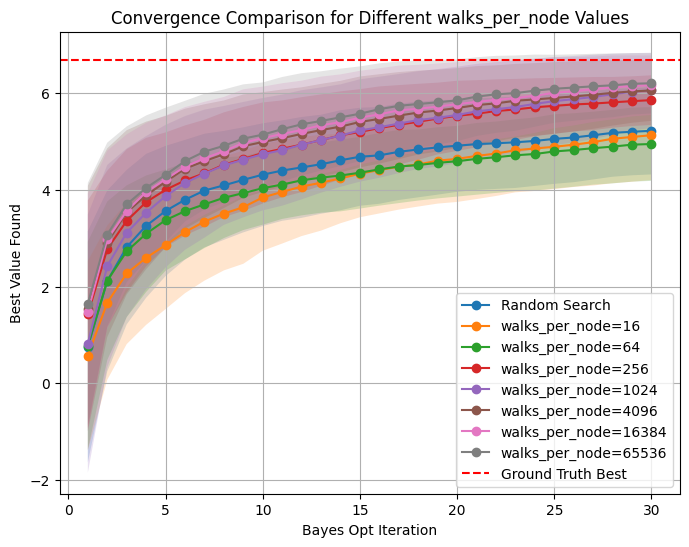

In [19]:
# Aggregate results: compute mean and std of best_value for each walks_per_node and iteration.
agg_df = GRF_df.groupby(['walks_per_node', 'iteration'], as_index=False).agg(
    best_value_mean=('best_value', 'mean'),
    best_value_std=('best_value', 'std'),
    ground_truth_best=('ground_truth_best', 'first'),
    sparsity=('sparsity', 'first')  # include sparsity if you want to report it
)

plt.figure(figsize=(8, 6))
for wpn in agg_df['walks_per_node'].unique():
    sub_df = agg_df[agg_df['walks_per_node'] == wpn].copy()
    x = sub_df['iteration'].astype(float).values
    y = sub_df['best_value_mean'].astype(float).values
    y_err = sub_df['best_value_std'].astype(float).values
    label = f'walks_per_node={wpn}' if wpn != 0 else 'Random Search'
    plt.plot(x, y, marker='o', label=label)
    plt.fill_between(x, y - y_err, y + y_err, alpha=0.2)

gt_best = float(agg_df['ground_truth_best'].iloc[0])
plt.axhline(y=gt_best, color='red', linestyle='--', label='Ground Truth Best')

plt.xlabel('Bayes Opt Iteration')
plt.ylabel('Best Value Found')
plt.title('Convergence Comparison for Different walks_per_node Values')
plt.legend()
plt.grid(True)
plt.show()

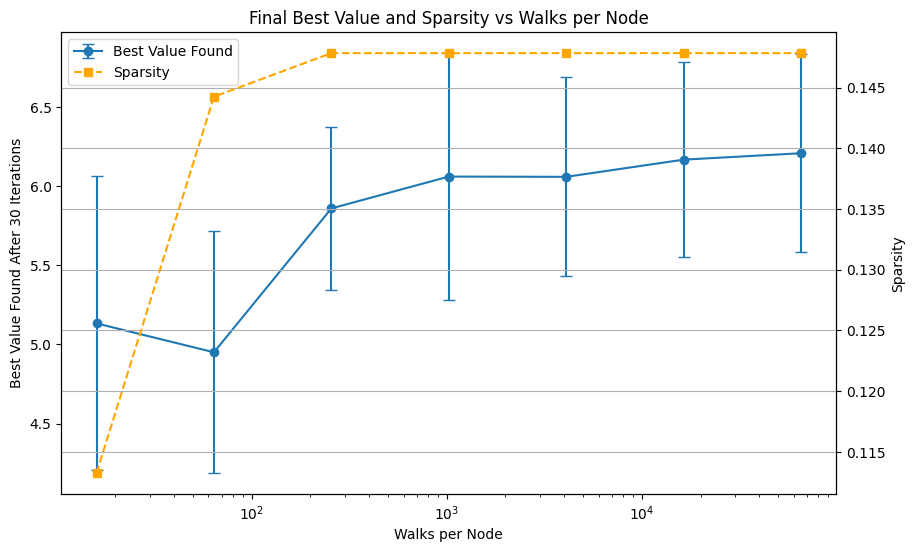

In [20]:
# Aggregate final-iteration results (iteration == NUM_ITER)
final_df = GRF_df[(GRF_df['iteration'] == NUM_ITER) & (GRF_df['walks_per_node'] != 0)].groupby('walks_per_node', as_index=False).agg(
    best_value_mean=('best_value', 'mean'),
    best_value_std=('best_value', 'std'),
    sparsity=('sparsity', 'first')
)

fig, ax1 = plt.subplots(figsize=(10, 6))
ax2 = ax1.twinx()

x = final_df['walks_per_node']
y1 = final_df['best_value_mean']
y1_err = final_df['best_value_std']
y2 = final_df['sparsity']

# Plot the best value (with error bars) on the left y-axis
ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', capsize=4, label='Best Value Found')
ax1.set_xlabel('Walks per Node')
ax1.set_ylabel(f'Best Value Found After {NUM_ITER} Iterations')
ax1.set_xscale('log')

# Plot the sparsity on the right y-axis
ax2.plot(x, y2, 's--', color='orange', label='Sparsity')
ax2.set_ylabel('Sparsity')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.title('Final Best Value and Sparsity vs Walks per Node')
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
from IPython.display import clear_output
import pandas as pd
import numpy as np

def plot_for_iteration(iteration):
    clear_output(wait=True)  # Clear previous output
    
    # Filter for the given iteration and nonzero walks_per_node, and make a copy
    df_iter = GRF_df[(GRF_df['iteration'] == iteration) & (GRF_df['walks_per_node'] != 0)].copy()
    
    # Convert best_value to a numeric value if it is a list/array (extract first element)
    df_iter['best_value'] = df_iter['best_value'].apply(
        lambda x: float(x[0]) if (isinstance(x, (list, np.ndarray)) and len(x) > 0) else float(x)
    )
    
    if df_iter.empty:
        print(f"No data available for iteration {iteration}.")
        return
    
    # Function to drop the most extreme seed result per walks_per_node group based on best_value
    def drop_extreme_seed(group):
        if len(group) > 1:
            group_copy = group.copy()
            # Compute the median best_value for the group
            median_val = group_copy['best_value'].median()
            # Calculate absolute deviation from the median
            group_copy['deviation'] = (group_copy['best_value'] - median_val).abs()
            # Identify the index with the maximum deviation and drop that row
            idx_to_drop = group_copy['deviation'].idxmax()
            return group_copy.drop(idx_to_drop)
        else:
            return group

    # Apply the dropping function for each walks_per_node group
    filtered_df = df_iter.groupby('walks_per_node', group_keys=False).apply(drop_extreme_seed)
    
    # Aggregate the remaining results per walks_per_node
    final_df = filtered_df.groupby('walks_per_node', as_index=False).agg(
        best_value_mean=('best_value', 'mean'),
        best_value_std=('best_value', 'std'),
        sparsity=('sparsity', 'first')
    )
    
    # Plotting
    fig, ax1 = plt.subplots(figsize=(6, 4))
    ax2 = ax1.twinx()
    
    x = final_df['walks_per_node']
    y1 = final_df['best_value_mean']
    y1_err = final_df['best_value_std']
    y2 = final_df['sparsity']
    
    # Plot best value with error bars on the left y-axis
    ax1.errorbar(x, y1, yerr=y1_err, fmt='o-', capsize=4, label='Best Value Found')
    ax1.set_xlabel('Walks per Node')
    ax1.set_ylabel(f'Best Value Found After {iteration} Iterations')
    ax1.set_xscale('log')
    
    # Plot sparsity on the right y-axis
    ax2.plot(x, y2, 's--', color='orange', label='Sparsity')
    ax2.set_ylabel('Sparsity')
    
    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='best')
    
    plt.title('Final Best Value and Sparsity vs Walks per Node')
    plt.grid(True)
    plt.show()

# Define slider range based on available iterations in GRF_df
min_iter = GRF_df['iteration'].min()
max_iter = GRF_df['iteration'].max()

interact(plot_for_iteration, iteration=IntSlider(min=min_iter, max=max_iter, step=1, value=min_iter));


interactive(children=(IntSlider(value=1, description='iteration', max=30, min=1), Output()), _dom_classes=('wi…